### Создание алгоритма генерации сигнала с равномерным спектром в заданном диапазоне частот

In [1]:
import numpy as np
from numpy.fft import fft, rfft, rfftfreq
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

**Идея**: Требуется создать сигнал с равномерным спектром в заданном диапазоне частот. В python реализован пакет **fft** в библиотеке **Numpy**, работающий с сигналами и различными преобразованиями. Из прикладных соображений имеются начальные данные и условия, которым сигнал должен отвечать.

**Описание переменных**:<br>
**N** - длина сигнала;<br>
**FD** - частота дискретизации сигнала;<br>
**A** - амплитуда сигнала;<br>
**p0** - базовый уровень давления;<br>
**(freq1, freq2)** - требуемый частотный диапазон сигнала<br>

Длина сигнала выбирается из соображений, что требуется сгенерировать 10 периодов сигнала частоты 100 Гц, что дает длина - 0.1 секунды. При частоте дискретизации 120000 Гц длина массива составит 12000 элементов. Требуемый уровень звукового давления сигнала должен быть порядка 100 дБ, что составляет 2 Па.

In [7]:
N = 12000
FD = 120000
A = 2
p0 = 2 * 10 ** (-5)
freq1 = 100
freq2 = 3000

Создадим функцию работающую от обратного, а именно, по заданному спектру сгенерируем сигнал.

In [4]:
def spectrum_noise(spectrum_func, samples, rate, A):
    freqs = np.fft.rfftfreq(samples, 1.0 / rate)
    spectrum = np.zeros_like(freqs, dtype='complex')
    spectrum[1:] = spectrum_func(freqs[1:])
    phases = np.random.rand(len(spectrum[1:])) * 2 * np.pi
    spectrum[1:] *= N * A * np.exp(1j * phases)
    noise = np.fft.irfft(spectrum)
    noise = np.pad(noise, (0, samples - len(noise)), 'constant')
    return noise


def band(f, f_min, f_max):
    f[np.logical_or(f < f_min, f > f_max)] = 0
    f[np.logical_and(f >= f_min, f <= f_max)] = 1
    return f

In [8]:
noise = spectrum_noise(lambda x: band(x, freq1, freq2), N, FD, A)
spectrum = 20 * np.log10(np.abs(rfft(noise)) / (N * p0))

c:\users\acer\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log10



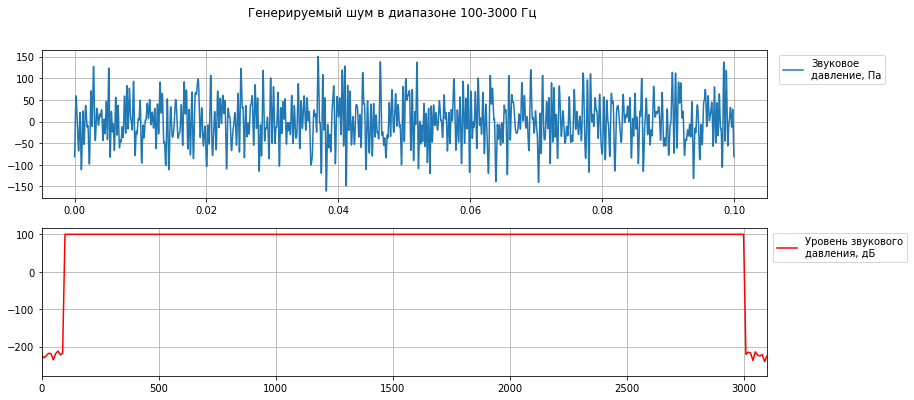

In [50]:
plt.rcParams["figure.figsize"] = (13,6)
fig, axs = plt.subplots(2)
fig.suptitle(f'Генерируемый шум в диапазоне {freq1}-{freq2} Гц')
axs[0].plot(np.arange(N) / FD, noise, label='Звуковое\nдавление, Па')
axs[1].plot(rfftfreq(N, 1. / FD), spectrum, label='Уровень звукового\nдавления, дБ', c='r')
axs[1].set_xlim(0, 3100)
axs[0].grid()
axs[1].grid()
axs[0].legend(loc='upper right', bbox_to_anchor=(1.17, 1))
axs[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))

In [15]:
# Запись в файл
path_to_write = ''

with open(path_to_write, 'w') as f:
    f.write('((outlet transient 12000 1)\n')
    f.write('(time\n')

    for i in np.arange(N) / FD:
        f.write('%s\n' % i)
    f.write(')\n')
    f.write('(pressure\n')

    for j in noise:
        f.write('%s\n' % j)

    f.write('))')